In [120]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py

importlib.reload(data_loading)

<module 'data_loading' from '/Users/ilyadavidson/Stanford_Internship/judge_project/data_loading.py'>

In [412]:
import importlib, api_call
importlib.reload(api_call)
import pandas as pd
from data_loading import build_cap_dataset, court_listener_cleaner
from main import judges_promoted_from_district
from helper_functions import norm_id
from helper_functions import plot_distributions
from api_call import _extract_text
from api_call import load_case_results
import json
import seaborn as sns
from api_call import system_msg, developer_msg, user_template 

In [ ]:
promoted        = pd.read_csv('results/promoted_judge_stats.csv')
judges          = pd.read_csv('data/judge_info.csv')
with open("results/appellate_matches.json", "r", encoding="utf-8") as f:
    app_matches = json.load(f)   
df = build_cap_dataset()
court_listener = pd.read_csv('third_circuit_on_appeal.csv')

Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


In [336]:
cl = pd.read_csv('third_circuit_on_appeal.csv')
cl = cl[cl['docket_number'].notna()] # remove nas
cl = cl.drop_duplicates(subset="docket_number", keep="first") # drop dupes

In [340]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = df["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 2705
Overlap by substring with CAP: 1915
No overlap with CAP: 790


In [344]:
overlap = cl[cl['overlap_by_substring']==True]

In [ ]:
court_listener = court_listener_cleaner(cl, judges, "combined_preview", df, "docket_number", "unique_id") 

In [ ]:
court_listener = court_listener_cleaner(cl, judges, "combined_preview", df, "docket_number", "unique_id") # 2705 cases go in and come out
court_listener = court_listener[court_listener['judge id'].notna()] # 1323 cases had a judge name that could be matched to a judge id
court_listener = court_listener[court_listener['unique_id'].notna()] # 1915 cases had a docket number that could be matched to CAP
court_listener = court_listener.drop_duplicates(subset="unique_id", keep="first") # we end up with 683 unique cases that have a judge id and docket number that matches CAP

In [361]:
len(court_listener)

683

In [362]:
len(df[df['is_appellate']==1])

51339

In [363]:
df[df['is_appellate']==1].sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate,docket_norm,overlap
73781,Idona WALLACE v. KMART CORPORATION (D.V.I. No....,No. 11-1541,2012-07-25,United States Court of Appeals for the Third C...,U.S.,687 Federal Reporter 3d Series 86,"166 Federal Reporter 3d Series 581, 487 United...","Before: FISHER, GREENAWAY, JR. and ROTH, Circu...","[fisher, greenaway, roth]","[3047, 911, 2063]",majority,"GREENAWAY, JR., Circuit Judge.",greenaway,911.0,"OPINION\nGREENAWAY, JR., Circuit Judge.\nAttor...",73781,1,NO111541,False


In [364]:
appellate_ids = df[df['is_appellate'] == 1]['unique_id'].astype(str)
matched = appellate_ids.isin(app_matches.keys()).sum()
print(f"We were able to match {matched} out of {len(appellate_ids)} appellate cases ({matched/len(appellate_ids):.2%})")

We were able to match 5818 out of 51339 appellate cases (11.33%)


In [368]:
print(f"With the court listener data we have {len(court_listener)+matched} appellate cases with outcomes.")

With the court listener data we have 6501 appellate cases with outcomes.


In [171]:
print(f"There are {len(judges['judge id'].unique())} total judges.") # total number of judges in dataset

aj = judges[judges['court type'].str.contains('Appeals|Circuit', case=False, na=False)]

print(f"There are {len(aj['judge id'].unique())} appellate judges") # unique appellate judges

dj = judges[judges['court type'].str.contains('District')]

print(f"There are {len(dj['judge id'].unique())} district judges") # unique district judges

There are 4026 total judges.
There are 882 appellate judges
There are 3277 district judges


In [172]:
def promotion_info_judges(judge_info):
    """
    Returns a df of all judges who got promoted from district to appellate courts. Their promotion date is the earliest nomination date that they got to the appellate court. 
    """
    ji = judge_info.copy()
    ji['promotion date'] = pd.NaT

    aj = ji[ji['court type'].str.contains('Appeals|Circuit', case=False, na=False)]
    dj = ji[ji['court type'].str.contains('District')]
    pj = dj[dj['judge id'].isin(aj['judge id'])].copy()
    pj['nomination date'] = pd.to_datetime(pj['nomination date'], errors='coerce')
    pj = pj.sort_values(['judge id','nomination date']).drop_duplicates('judge id', keep='first')

    ji['is promoted'] = ji['judge id'].isin(pj['judge id']).astype(int)
    ji['promotion date'] = ji.apply(lambda row: pj[pj['judge id']==row['judge id']]['nomination date'].values[0] if row['is promoted'] else pd.NaT, axis=1)
    ji_district = ji[ji['court type'].str.contains('District')]
    ji_district = ji_district.drop_duplicates('judge id', keep='first')
    return ji_district

In [173]:
dsct_jdges = promotion_info_judges(judges) # district judges with promotion info
len(dsct_jdges)

3277

In [174]:
dsct_jdges.sample(1)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,promotion date,is promoted
410,264,bristol,William,Male,White,1779,Hamden,CT,1836.0,New Haven,...,,1826-05-22,1826-05-22,Yale College,NaN,Read law,NaN,"Private practice, New Haven, Connecticut, 1800...",NaT,0


In [17]:
len(dsct_jdges[dsct_jdges['is promoted']==1]) / len(dsct_jdges) * 100 # proportion of district judges who got promoted

9.826060421116875

In [18]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)]) / len(dsct_jdges[dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")]) * 100 # proportion of district judges in the third court who got promoted

11.411411411411411

In [19]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)])

38

In [20]:
thrd_judges = dsct_jdges[dsct_jdges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

In [460]:
def compute_district_overturns(
    df:             pd.DataFrame,
    dsct_judges:    pd.DataFrame,
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
    court_listener: pd.DataFrame = None,
    overlap_path:   str = "batch_runs/overlap_outputs/overlap_results.jsonl",
) -> pd.DataFrame:
    """
    Compute district-level overturn counts & rates per judge.

    Reads:
      - mapping_path: JSON mapping {appellate_custom_id -> district_unique_id}
      - api_path:     JSONL with batch responses (has custom_id + response)
      - overlap_path: (optional) another JSONL of the same schema to merge in

    Notes:
      * Responses from api_path and overlap_path are merged and de-duped by custom_id.
      * We only need the 'opinion' field parsed from the model text; 'affirmed' vs non-affirmed.
    """
    pj                     = dsct_judges.copy()
    dsc                    = df[df['is_appellate'] == 0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id)

    by_judge_cases = (
        dsc
        .dropna(subset=["_author_id_norm"])
        .groupby("_author_id_norm")
        .apply(lambda g: list(g.index))
        .to_dict()
    )

    pj["_judge_id_norm"]      = pj["judge id"].map(norm_id)
    pj["district_cases_list"] = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else [])
    pj["district cases"]      = pj["district_cases_list"].str.len().astype(int)

    # ----- Load mapping -----
    try:
        with open(mapping_path, "r", encoding="utf-8") as f:
            app_to_dct = json.load(f)
    except FileNotFoundError:
        app_to_dct = {}

    # ----- Helper to read/parse a JSONL of batch results -----
    def _read_batch_jsonl(path: str) -> dict[str, str]:
        """
        Returns {custom_id -> opinion_string_lower} from a JSONL results file.
        Safely ignores bad lines or missing fields.
        """
        out: dict[str, str] = {}
        if not path:
            return out
        try:
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    if not line.strip():
                        continue
                    try:
                        rec = json.loads(line)
                    except Exception:
                        continue
                    if rec.get("error"):
                        continue
                    txt = _extract_text(rec.get("response", {}))
                    if not txt:
                        continue
                    try:
                        obj = json.loads(txt)
                    except json.JSONDecodeError:
                        continue
                    opinion = (obj.get("opinion") or "").strip().lower()
                    cid     = str(rec.get("custom_id") or "")
                    if cid:
                        # keep first seen (stable) — avoids flip-flopping if duplicates exist
                        out.setdefault(cid, opinion)
        except FileNotFoundError:
            pass
        return out

    # ----- Load opinions from BOTH files and merge/dedupe -----
    opinions_primary  = _read_batch_jsonl(api_path)
    opinions_overlap  = _read_batch_jsonl(overlap_path)
    opinions          = {**opinions_overlap, **opinions_primary}
    # ^ merge strategy: keep 'opinions_primary' preference on conflict (last write wins).
    # If you prefer overlap to win, flip the order.

    # ----- Build overturned district index set using mapping + opinions -----
    overturned_district_indices: set[int] = set()
    for cid, opinion in opinions.items():
        if opinion and opinion != "affirmed":
            if cid in app_to_dct:
                try:
                    overturned_district_indices.add(int(app_to_dct[cid]))
                except Exception:
                    pass

    # Appeals coverage count (mapping-based)
    appealed_district_cases = set(app_to_dct.values())
    pj["appealed cases"] = pj["district_cases_list"].apply(
        lambda case_list: sum(1 for cid in case_list if cid in appealed_district_cases)
    ).astype(int)

    # ===== CourtListener: add tallies to district & appealed (no extra column) =====
    if court_listener is not None and not court_listener.empty:
        cl = court_listener.copy()
        cl["judge id"] = pd.to_numeric(cl["judge id"], errors="coerce").astype("Int64")
        cl = cl.dropna(subset=["judge id", "docket_number"])
        cl["docket_number"] = cl["docket_number"].astype(str)

        cl_counts = (
            cl.groupby("judge id")["docket_number"]
              .nunique()
              .astype(int)
        )

        add_series = pj["judge id"].map(cl_counts).fillna(0).astype(int)
        pj["district cases"] = (pj["district cases"] + add_series).astype(int)
        pj["appealed cases"] = (pj["appealed cases"] + add_series).astype(int)

    # ----- Overturned (mapping-only baseline) -----
    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["overturned_from_mapping"] = pj["district_cases_list"].apply(_count_overturned).astype(int)

    # ----- CourtListener overlap augmentation (overturned) -----
    extra_overturned_by_judge: dict[int, int] = {}

    if court_listener is not None and not court_listener.empty:
        cl2 = court_listener.dropna(subset=["docket_number"]).copy()
        cl2["judge id"] = pd.to_numeric(cl2["judge id"], errors="coerce").astype("Int64")
        cl2 = cl2.dropna(subset=["judge id"])
        cl_dockets = cl2["docket_number"].astype(str).dropna().unique().tolist()

        def has_overlap(docket: str) -> bool:
            if not isinstance(docket, str):
                return False
            return any(docket in cl_d or cl_d in docket for cl_d in cl_dockets)

        df_local = df.copy()
        df_local["__has_docket"] = df_local["docket_number"].notna()
        df_local["overlap"] = False
        mask = df_local["__has_docket"]
        df_local.loc[mask, "overlap"] = df_local.loc[mask, "docket_number"].astype(str).apply(has_overlap)

        overlap_cases = df_local[df_local["overlap"] & df_local["unique_id"].notna()].copy()
        overlap_cases["unique_id"] = overlap_cases["unique_id"].astype(str)

        cl_rows = cl2[["docket_number", "judge id"]].copy()
        cl_rows["docket_number"] = cl_rows["docket_number"].astype(str)

        # Use merged 'opinions' (primary + overlap) for non-affirmed check
        for df_docket, block in overlap_cases.groupby("docket_number"):
            df_docket = str(df_docket)
            cl_judges = set(
                int(j) for d, j in zip(cl_rows["docket_number"], cl_rows["judge id"])
                if (df_docket in d) or (d in df_docket)
            )
            if not cl_judges:
                continue

            uids_here = set(block["unique_id"].astype(str).unique())
            non_aff = [u for u in uids_here if (opinions.get(u, "").lower() not in ("", "affirmed"))]
            if not non_aff:
                continue

            for jid in cl_judges:
                extra_overturned_by_judge[jid] = extra_overturned_by_judge.get(jid, 0) + 1

    def _cl_extra_for_row(row) -> int:
        jid = row.get("judge id")
        if pd.isna(jid):
            return 0
        return int(extra_overturned_by_judge.get(int(jid), 0))

    pj["overturned_from_cl"] = pj.apply(_cl_extra_for_row, axis=1).astype(int)

    # ----- Combine + rates -----
    pj["district_cases_overturned"] = pj["overturned_from_mapping"] + pj["overturned_from_cl"]
    pj["district_overturn_rate"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj["overturn_rate_among_appeals"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["appealed cases"]) if r["appealed cases"] else pd.NA,
        axis=1
    )

    pj.drop(columns=["_judge_id_norm"], inplace=True)

    # dtypes
    pj["judge id"]                  = pd.to_numeric(pj["judge id"], errors="coerce").astype("Int64")
    pj["district cases"]            = pd.to_numeric(pj["district cases"], errors="coerce").astype(int)
    pj["appealed cases"]            = pd.to_numeric(pj["appealed cases"], errors="coerce").astype(int)
    pj["overturned_from_mapping"]   = pd.to_numeric(pj["overturned_from_mapping"], errors="coerce").astype(int)
    pj["overturned_from_cl"]        = pd.to_numeric(pj["overturned_from_cl"], errors="coerce").astype(int)
    pj["district_cases_overturned"] = pd.to_numeric(pj["district_cases_overturned"], errors="coerce").astype(int)

    return pj

In [468]:
overturns = compute_district_overturns(df, thrd_judges, court_listener=cl)

KeyError: 'is_appellate'

## non-overlap api call

In [440]:
cl_non_overlap = cl[cl['overlap_by_substring']==False]

In [450]:
cl_non_overlap = cl_non_overlap.rename(columns={'combined_preview': 'opinion_text', 'cluster_id': 'unique_id'})
cl_non_overlap['is_appellate'] = 1

In [ ]:
from api_call import _build_full_input, _enqueue_chunks
from pathlib import Path
input_path = Path("batch_runs/overlap_input.jsonl")
_build_full_input(cl_non_overlap, input_path)

[Build] Wrote 790 requests -> batch_runs/overlap_input.jsonl


790

In [455]:
from __future__ import annotations
import time, json
from pathlib import Path
from typing import Optional, Tuple, List
from dotenv import load_dotenv
from openai import OpenAI

# ---------- Config ----------
INPUT_PATH          = Path("batch_runs/overlap_input.jsonl")   # already created
OUTPUT_DIR          = Path("batch_runs/overlap_outputs")       # NEW folder for this run
MERGED_RESULTS_PATH = OUTPUT_DIR / "overlap_results.jsonl"     # NEW results file
ENDPOINT            = "/v1/chat/completions"                    # or "/v1/responses" if you used Responses API in the input
COMPLETION_WINDOW   = "24h"                                     # typical batch window; adjust as needed
POLL                = True                                      # set False if you don't want to poll
POLL_INTERVAL       = 20                                        # seconds


def enqueue_single_file(inp: Path, endpoint: str, completion_window: str) -> str:
    """Upload one JSONL and create a single batch. Returns batch_id."""
    load_dotenv()
    client = OpenAI()
    with inp.open("rb") as fh:
        file_obj = client.files.create(file=fh, purpose="batch")
    batch = client.batches.create(
        input_file_id     = file_obj.id,
        endpoint          = endpoint,
        completion_window = completion_window,
        metadata          = {"description": f"Batch for {inp.name}"},
    )
    print(f"[Batch] Created {batch.id} for {inp.name}")
    return batch.id


def download_outputs_for_batch(batch_id: str, out_dir: Path, poll: bool, poll_interval: int = 20) -> Tuple[Optional[Path], Optional[Path]]:
    """
    Optionally poll a single batch to completion, then download outputs/errors.
    Returns (results_path, errors_path) — either may be None if not present.
    """
    load_dotenv()
    client = OpenAI()
    out_dir.mkdir(parents=True, exist_ok=True)

    terminal = {"completed", "failed", "cancelled", "expired"}
    while True:
        b = client.batches.retrieve(batch_id)
        st = getattr(b, "status", None)
        print(f"[Poll] {batch_id} status={st}")
        if not poll or st in terminal:
            break
        time.sleep(poll_interval)

    results_path = None
    errors_path  = None

    out_id = getattr(b, "output_file_id", None)
    if out_id:
        results_path = out_dir / f"{batch_id}_results.jsonl"
        if not results_path.exists():  # don't clobber if re-running
            stream = client.files.content(out_id)
            with results_path.open("wb") as f:
                f.write(stream.read())
        print(f"[Download] results -> {results_path}")

    err_id = getattr(b, "error_file_id", None)
    if err_id:
        errors_path = out_dir / f"{batch_id}_errors.jsonl"
        if not errors_path.exists():
            stream = client.files.content(err_id)
            with errors_path.open("wb") as f:
                f.write(stream.read())
        print(f"[Download] errors  -> {errors_path}")

    return results_path, errors_path


def merge_fresh_results(merged_path: Path, batch_result_files: List[Path]) -> Tuple[int, int]:
    """
    Write a brand-new merged file only from the provided batch_result_files.
    Dedupes by custom_id within these files. Does NOT read or touch old outputs.
    Returns (unique_kept, dropped_dupes_within_these_files).
    """
    seen: set[str] = set()
    kept_lines: List[str] = []
    dropped = 0

    for p in batch_result_files:
        if not p or not p.exists():
            continue
        with p.open("r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    rec = json.loads(line)
                except Exception:
                    continue
                cid = str(rec.get("custom_id"))
                if cid in seen:
                    dropped += 1
                    continue
                seen.add(cid)
                kept_lines.append(line)

    merged_path.parent.mkdir(parents=True, exist_ok=True)
    with merged_path.open("w", encoding="utf-8") as out:
        out.writelines(kept_lines)

    print(f"[Merge] Wrote {merged_path} | Unique={len(seen)} | Dropped dupes={dropped}")
    return len(seen), dropped


if __name__ == "__main__":
    # 1) create batch
    batch_id = enqueue_single_file(INPUT_PATH, ENDPOINT, COMPLETION_WINDOW)

    # 2) (optional) poll & download this batch's outputs/errors ONLY into the new folder
    res_path, err_path = download_outputs_for_batch(batch_id, OUTPUT_DIR, poll=POLL, poll_interval=POLL_INTERVAL)

    # 3) Merge just-downloaded results into a new, isolated merged file
    #    (This does NOT read any old outputs; it only uses this run's files.)
    present = [p for p in [res_path] if p is not None]
    merge_fresh_results(MERGED_RESULTS_PATH, present)

    print(f"\nDone. Your fresh results are in: {MERGED_RESULTS_PATH}")

[Batch] Created batch_68e2d984411c8190b56ae5bf48e30342 for overlap_input.jsonl
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=validating
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=validating
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=validating
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=validating
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68e2d984411c8190b56ae5bf48e30342 status=in_progress
[Poll] batch_68

APIConnectionError: Connection error.

In [456]:
batch_id = "batch_68e2d984411c8190b56ae5bf48e30342"  # ← replace with the actual ID printed before
client = OpenAI()
batch = client.batches.retrieve(batch_id)
print(batch.status)

completed


In [457]:
out_id = batch.output_file_id
if out_id:
    stream = client.files.content(out_id)
    with open("batch_runs/overlap_outputs/overlap_results.jsonl", "wb") as f:
        f.write(stream.read())
    print("✅ Downloaded overlap_results.jsonl")

✅ Downloaded overlap_results.jsonl


In [469]:
overturns = compute_district_overturns(df, thrd_judges, court_listener=court_listener)

KeyError: 'is_appellate'

In [369]:
overturns = compute_district_overturns(df, thrd_judges, court_listener=court_listener)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1094268343.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [376]:
overturns

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
4,2,acheson,Marcus,Male,White,1828,Washington,PA,1906.0,Pittsburgh,...,1880-01-06,1,"[78820, 78821, 78824, 78825, 78847, 78849, 788...",41,6,0,0,0,0.0,0.0
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
89,57,archbald,Robert,Male,White,1848,Carbondale,PA,1926.0,Martha`s Vineyard,...,1901-12-05,1,"[79660, 79684, 79733, 79734, 79747, 79748, 797...",78,3,2,0,2,0.025641,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571
4006,2676,young,James,Male,White,1848,Pittsburgh,PA,1914.0,,...,NaT,0,"[81273, 81380, 81478, 81540, 81541, 81590, 816...",24,7,2,0,2,0.083333,0.285714
4012,6839686,younge,John,Male,African American,1955,Philadelphia,PA,NaN,NaN,...,NaT,0,[],0,0,0,0,0,<NA>,<NA>


In [74]:
import json

# Build the opinions dictionary from api_responses.jsonl
opinions = {}
with open("batch_runs/api_responses.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        rec = json.loads(line)
        if rec.get("error"):
            continue
        txt = _extract_text(rec.get("response", {}))
        if not txt:
            continue
        try:
            obj = json.loads(txt)  # your 9-key model output
        except json.JSONDecodeError:
            continue
        op = (obj.get("opinion") or "").strip().lower()
        cid = str(rec.get("custom_id"))
        if cid:
            opinions[cid] = op

In [255]:
overturns

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
4,2,acheson,Marcus,Male,White,1828,Washington,PA,1906.0,Pittsburgh,...,1880-01-06,1,"[78820, 78821, 78824, 78825, 78847, 78849, 788...",41,6,0,0,0,0.0,0.0
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
89,57,archbald,Robert,Male,White,1848,Carbondale,PA,1926.0,Martha`s Vineyard,...,1901-12-05,1,"[79660, 79684, 79733, 79734, 79747, 79748, 797...",78,3,2,0,2,0.025641,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571
4006,2676,young,James,Male,White,1848,Pittsburgh,PA,1914.0,,...,NaT,0,"[81273, 81380, 81478, 81540, 81541, 81590, 816...",24,7,2,0,2,0.083333,0.285714
4012,6839686,younge,John,Male,African American,1955,Philadelphia,PA,NaN,NaN,...,NaT,0,[],0,0,0,0,0,<NA>,<NA>


In [390]:
bt10 = overturns[overturns['appealed cases']>=10]

In [391]:
bt10

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
110,71,augelli,Anthony,Male,White,1902,Orsara,Italy,1985.0,Spring Lake Heights,...,NaT,0,"[17063, 17138, 17168, 17217, 17224, 17233, 172...",54,13,7,0,7,0.12963,0.538462
149,93,bard,Guy,Male,White,1895,Lincoln,PA,1953.0,,...,NaT,0,"[11177, 11193, 11206, 11216, 11227, 11263, 112...",328,47,17,0,17,0.051829,0.361702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,2638,wood,Harold,Male,White,1906,Mount Vernon,NY,1972.0,Philadelphia,...,NaT,0,"[16298, 16312, 16321, 16364, 16377, 16382, 163...",321,49,23,0,23,0.071651,0.469388
3977,2656,wortendyke,Reynier,Male,White,1895,Jersey City,NJ,1975.0,,...,NaT,0,"[15067, 15078, 15110, 15122, 15134, 15157, 151...",273,51,21,0,21,0.076923,0.411765
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571


In [392]:
bt10[bt10['is promoted']==0]['overturn_rate_among_appeals'].mean()

np.float64(0.456445505221841)

In [393]:
bt10.groupby("is promoted")["district cases"].mean()

is promoted
0    233.741497
1    213.400000
Name: district cases, dtype: float64

In [394]:
bt10.groupby("is promoted")["overturn_rate_among_appeals"].mean()

is promoted
0    0.456446
1    0.365996
Name: overturn_rate_among_appeals, dtype: object

In [395]:
promoted_mean = bt10[bt10["is promoted"] == 1]["overturn_rate_among_appeals"].mean()
not_promoted_mean = bt10[bt10["is promoted"] == 0]["overturn_rate_among_appeals"].mean()
effect = promoted_mean - not_promoted_mean
print("Average effect of being promoted:", effect)

Average effect of being promoted: -0.09044963418129609


In [396]:
df.sample(1)['name'].iloc[0]

'Quaqua SUBAH, Petitioner v. ATTORNEY GENERAL OF the UNITED STATES, Respondent'

In [434]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

df = bt10.copy()

# Outcome (binary)
y = df["is promoted"].astype(float)  # 0/1 as float is fine for Logit/OLS

# Build design matrix
X = pd.DataFrame({
    "overturn_rate_among_appeals": pd.to_numeric(df["overturn_rate_among_appeals"], errors="coerce"),
    "gender": df["gender"].fillna("Unknown").astype("category"),
    "ethnicity": df["ethnicity"].fillna("Unknown").astype("category"),
})

# One-hot encode categoricals → numeric dtypes only
X = pd.get_dummies(X, columns=["gender", "ethnicity"], drop_first=True, dtype=float)

# Drop any rows with NA in y or X to keep arrays aligned
mask = ~(y.isna() | X.isna().any(axis=1))
y_clean = y.loc[mask]
X_clean = X.loc[mask]

# Add intercept
X_clean = sm.add_constant(X_clean, has_constant="add")

# Sanity check: all numeric?
assert np.issubdtype(X_clean.to_numpy().dtype, np.number), "X still contains non-numeric dtypes"
assert y_clean.notna().all(), "y contains NaN after masking"

# Fit models
logit_model = sm.Logit(y_clean, X_clean).fit()
print("=== Logistic Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===")
print(logit_model.summary())

ols_model = sm.OLS(y_clean, X_clean).fit()
print("\n=== OLS Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.336260
         Iterations 26
=== Logistic Regression: is promoted ~ overturn_rate_among_appeals + gender + ethnicity ===
                           Logit Regression Results                           
Dep. Variable:            is promoted   No. Observations:                  167
Model:                          Logit   Df Residuals:                      162
Method:                           MLE   Df Model:                            4
Date:                Sat, 04 Oct 2025   Pseudo R-squ.:                 0.08238
Time:                        11:21:59   Log-Likelihood:                -56.155
converged:                       True   LL-Null:                       -61.197
Covariance Type:            nonrobust   LLR p-value:                   0.03906
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [432]:
import statsmodels.api as sm

# Outcome: promotion (binary)
y = bt10["is promoted"].astype(int)

# Predictor: overturn rate (continuous, or binary if you want high/low)
X = bt10["overturn_rate_among_appeals"].astype(float)
X = sm.add_constant(X)  # add intercept

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print("=== Logistic Regression: is promoted ~ overturn_rate_among_appeals ===")
print(logit_model.summary())

# OLS regression (linear probability model)
ols_model = sm.OLS(y, X).fit()
print("\n=== OLS Regression: is promoted ~ overturn_rate_among_appeals ===")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.345747
         Iterations 7
=== Logistic Regression: is promoted ~ overturn_rate_among_appeals ===
                           Logit Regression Results                           
Dep. Variable:            is promoted   No. Observations:                  167
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Oct 2025   Pseudo R-squ.:                 0.05649
Time:                        11:20:57   Log-Likelihood:                -57.740
converged:                       True   LL-Null:                       -61.197
Covariance Type:            nonrobust   LLR p-value:                  0.008552
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
con

In [398]:
import statsmodels.api as sm

# Predictor and outcome
bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average
X = bt10["is promoted"].astype(float)
X = sm.add_constant(X)  # add intercept
y = bt10["high_overturn"]

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.595694
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          high_overturn   No. Observations:                  167
Model:                          Logit   Df Residuals:                      165
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.04669
Time:                        18:26:14   Log-Likelihood:                -99.481
converged:                       True   LL-Null:                       -104.35
Covariance Type:            nonrobust   LLR p-value:                  0.001799
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.6026      0.173     -3.493      0.000      -0.941      -0.265
is promoted    -2.3418    

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1460846486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average


In [399]:
case_results = load_case_results()
case_results.sample(1)

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
9757,affirmed,tort,legal error,male,company,2.0,high,None,None,62443


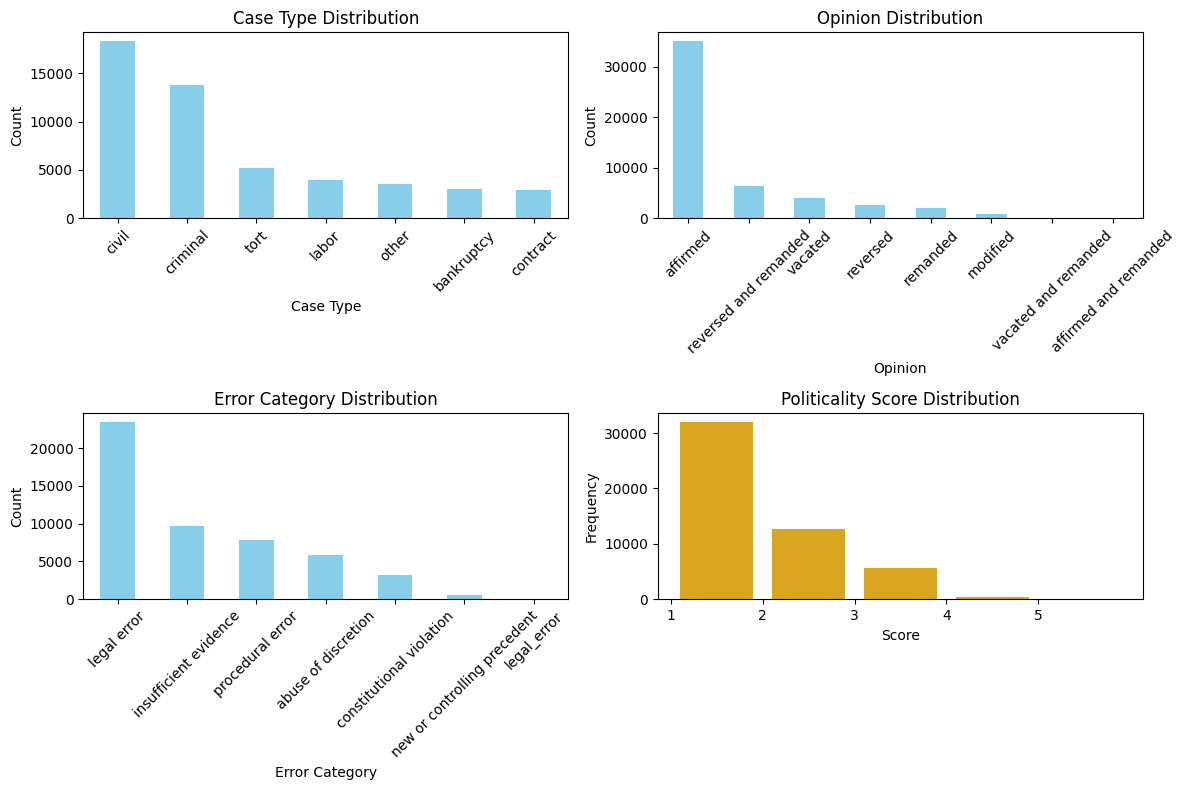

In [400]:
plot_distributions(case_results, ["case_type", "opinion", "error_category", "politicality_score"])

In [401]:
case_results.groupby('case_type').apply(
    lambda group: len(group[group['opinion'] == 'affirmed']) / len(group) * 100
)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/2251497098.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  case_results.groupby('case_type').apply(


case_type
bankruptcy    62.975098
civil         66.692186
contract      59.271978
criminal      75.139726
labor         57.838389
other         82.829978
tort          60.686728
dtype: float64

In [402]:
len(case_results[case_results['opinion']=='affirmed']) / len(case_results) * 100

68.16844893745497

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1331619923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["appealed cases"] = bt10["appealed cases"].astype(int)
/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1331619923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)


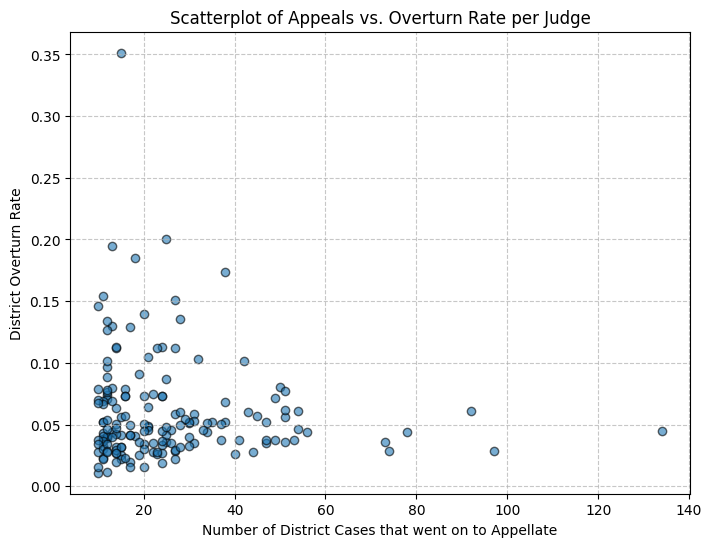

In [403]:
import matplotlib.pyplot as plt

# Example: use your DataFrame "bt10"
# Ensure numeric types
bt10["appealed cases"] = bt10["appealed cases"].astype(int)
bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)

plt.figure(figsize=(8,6))
plt.scatter(
    bt10["appealed cases"], 
    bt10["district_overturn_rate"], 
    alpha=0.6, edgecolor="k"
)

plt.xlabel("Number of District Cases that went on to Appellate")
plt.ylabel("District Overturn Rate")
plt.title("Scatterplot of Appeals vs. Overturn Rate per Judge")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [404]:
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Inputs you already have:
# df: cases DataFrame with index = district case id; columns include is_appellate, opinion_author_id
# pj: judges DataFrame with "judge id" and a column "district_cases_list" (list of district case ids per judge)
# mapping_path: JSON mapping {<appellate_id>: <district_index>}

mapping_path = "results/appellate_matches.json"

# 1) Build the set of *district* case ids that were appealed
with open(mapping_path, "r", encoding="utf-8") as f:
    app_to_dct = json.load(f)

appealed_district_ids = set()
for k, v in app_to_dct.items():
    try:
        appealed_district_ids.add(int(v))
    except Exception:
        continue

# 2) Per judge: count how many of their district cases were appealed (regardless of outcome)
def count_appealed(case_list):
    if not isinstance(case_list, (list, tuple)):
        return 0
    return sum(1 for cid in case_list if cid in appealed_district_ids)

pj = bt10.copy()
pj["appealed_cases"] = pj["appealed cases"]

# 3) Quick dispersion view: mean/median/std/CV and a few quantiles
summary = pj["appealed_cases"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])
cv = (pj["appealed_cases"].std(ddof=1) / max(summary["mean"], 1e-9))
print("Appealed cases per judge — summary stats")
print(summary)
print(f"Coefficient of Variation (std/mean): {cv:.3f}")

# (Optional) peek at a few extremes
print("\nTop 10 judges by appealed cases:")
print(pj[["judge id","appealed_cases","district cases"]].sort_values("appealed_cases", ascending=False).head(10))

print("\nBottom 10 judges by appealed cases (with at least 1 district case):")
print(pj[pj["district cases"]>0][["judge id","appealed_cases","district cases"]]
      .sort_values("appealed_cases", ascending=True).head(10))

# 4) Are judges getting “about the same” number appealed given exposure?
#    Test: assume a common appeal probability p across judges; compare observed vs expected with Pearson χ².
#    Only include judges with at least 1 district case to avoid division issues.
g = pj[pj["district cases"] > 0].copy()
n = g["district cases"].to_numpy(dtype=float)       # exposures (trials)
obs = g["appealed_cases"].to_numpy(dtype=float)

# Global appeal rate p-hat:
p_hat = obs.sum() / n.sum() if n.sum() > 0 else np.nan
exp = n * p_hat

# Filter out judges whose expected count is ~0 (no power there)
mask = exp > 0
obs2 = obs[mask]
exp2 = exp[mask]
k = obs2.size

if k >= 2 and np.isfinite(p_hat):
    chi2_stat = ((obs2 - exp2)**2 / exp2).sum()
    # degrees of freedom ~ (k - 1) because we estimated a single parameter p_hat
    df_ = max(k - 1, 1)
    p_value = 1 - chi2.cdf(chi2_stat, df_)
    print("\nGoodness-of-fit to a single common appeal rate (binomial with exposure):")
    print(f"- p_hat (overall appeal rate): {p_hat:.4f}")
    print(f"- Pearson χ²: {chi2_stat:.2f} on {df_} df  ->  p = {p_value:.4g}")
    if p_value < 0.05:
        print("⇒ Variation across judges is larger than expected if all shared the same appeal rate.")
    else:
        print("⇒ No strong evidence of heterogeneity; appealed counts look consistent with a common rate.")
else:
    print("\nNot enough data to run the goodness-of-fit test (check exposures).")

# 5) (Optional) Standardized residuals per judge to see who’s high/low relative to exposure
if k >= 2 and np.isfinite(p_hat):
    # Avoid division by zero
    denom = np.sqrt(np.maximum(exp, 1e-12))
    g["std_resid"] = (obs - exp) / denom
    print("\nJudges with largest positive residuals (more appeals than expected given exposure):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=False).head(10))
    print("\nJudges with most negative residuals (fewer appeals than expected):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=True).head(10))

Appealed cases per judge — summary stats
count    167.000000
mean      25.119760
std       17.959728
min       10.000000
10%       11.000000
25%       13.000000
50%       20.000000
75%       30.000000
90%       47.800000
95%       53.700000
max      134.000000
Name: appealed_cases, dtype: float64
Coefficient of Variation (std/mean): 0.715

Top 10 judges by appealed cases:
      judge id  appealed_cases  district cases
1969      1287             134             629
3071      2032              97            1133
1370       896              92             624
950        616              78             590
2267      1484              74             529
2424      1597              73             749
3802      2527              56             709
1184       773              54             388
2678      1763              54             245
3208      2118              53             347

Bottom 10 judges by appealed cases (with at least 1 district case):
      judge id  appealed_cases  distric

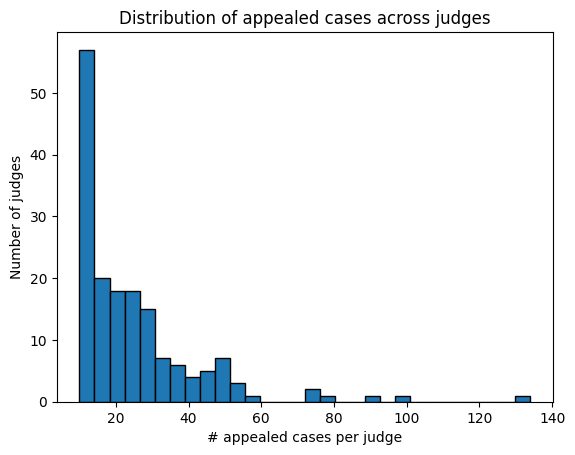

In [405]:
import matplotlib.pyplot as plt

plt.hist(pj["appealed_cases"], bins=30, edgecolor="black")
plt.xlabel("# appealed cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of appealed cases across judges")
plt.show()

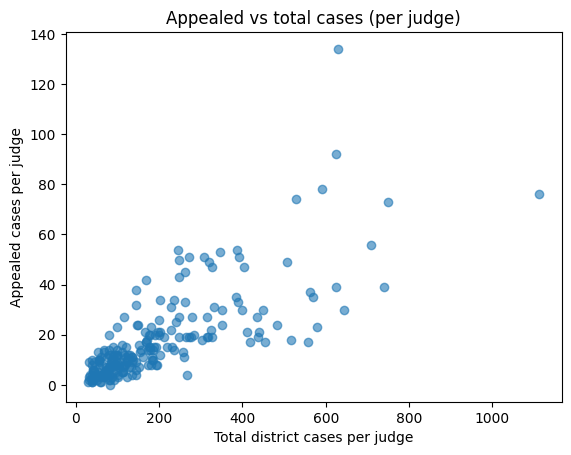

In [160]:
plt.scatter(pj["district cases"], pj["appealed_cases"], alpha=0.6)
plt.xlabel("Total district cases per judge")
plt.ylabel("Appealed cases per judge")
plt.title("Appealed vs total cases (per judge)")
plt.show()